In [1]:
# essentials
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow tools
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.resnet import ResNet152, preprocess_input as resnet_preprocess
from keras.preprocessing import image
from keras import Model
from keras.layers import Dense

# Loading data

In [2]:
# Filepaths to training and test sets
base_dir = './data/fruits-360_dataset/fruits-360'

train_dir = Path(base_dir + '/Training')
test_dir = Path(base_dir + '/Test')

In [3]:
# Getting a list of labels
label_list = os.listdir(train_dir)

In [4]:
# Fixed parameters
image_size = (224, 224, 3)
batch_size = 32
num_classes = len(label_list)

In [5]:
# Creating data generators for training and test sets
train_datagen = image.ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = image.ImageDataGenerator()

In [6]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    target_size=image_size[:-1]
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    target_size=image_size[:-1]
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    target_size=image_size[:-1]
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Models

In [7]:
# Building a pretrained model with a custom top function
def build_model(pretrained_model):
    x = Dense(256, activation='relu')(pretrained_model.output)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=pretrained_model.input, outputs=output)

In [8]:
def plot_sample(preprocess_function, model):
    test_datagen.preprocessing_function = None
    x_sample, y_sample = test_gen.next()
    x_orig = np.copy(x_sample)

    predictions = model.predict(preprocess_function(x_sample), verbose=0)

    fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_orig[i]/255.)
        ax.set_title(f'True: {label_list[np.argmax(y_sample[i])]}\nPredicted: {label_list[np.argmax(predictions[i])]}', fontsize=8)
    plt.tight_layout(pad=0.5)
    plt.show()

## VGG16

In [9]:
# Applying VGG16's preprocess function on train and test data generators
train_datagen.preprocessing_function = vgg16_preprocess
test_datagen.preprocessing_function = vgg16_preprocess

In [10]:
# Loading a pretrained model without the top
pretrained_model_vgg16 = VGG16(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_vgg16.trainable = False

In [11]:
# Model construction and compilation
model_vgg16 = build_model(pretrained_model_vgg16)
model_vgg16.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Model learning
model_vgg16.fit(train_gen, validation_data=validation_gen, epochs=2)

Epoch 1/2
1694/1694 [==============================] - 526s 308ms/step - loss: 0.2749 - accuracy: 0.9347 - val_loss: 0.0724 - val_accuracy: 0.9779
Epoch 2/2
1694/1694 [==============================] - 494s 292ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.0300 - val_accuracy: 0.9899


In [13]:
# Model evaluation
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(test_gen)

709/709 [==============================] - 86s 121ms/step - loss: 0.3174 - accuracy: 0.9354


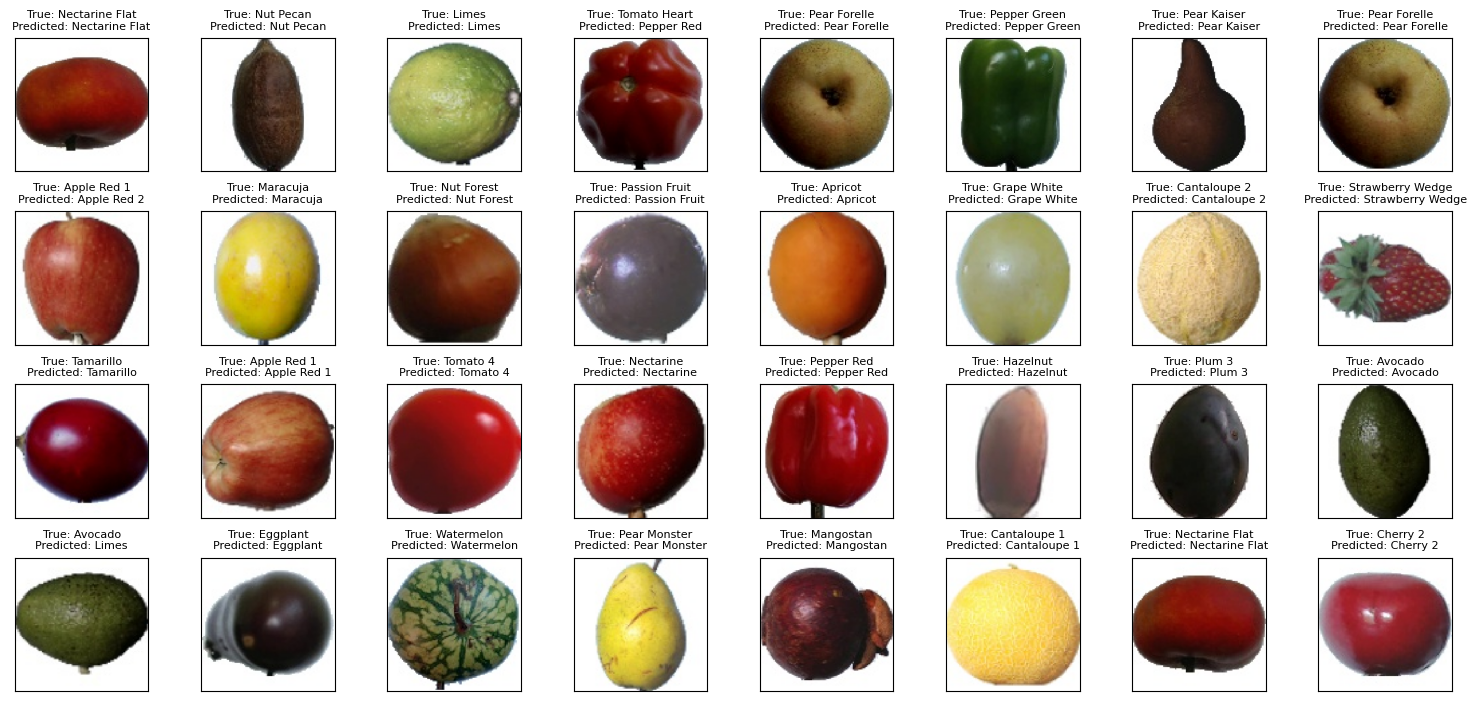

In [14]:
# Plotting a sample of images with predicted and true labels
plot_sample(vgg16_preprocess, model_vgg16)

## Xception

In [15]:
# Applying Xception's preprocess function on train and test data generators
train_datagen.preprocessing_function = xception_preprocess
test_datagen.preprocessing_function = xception_preprocess

In [16]:
# Loading a pretrained model without the top
pretrained_model_xception = Xception(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_xception.trainable = False

In [17]:
# Model construction and compilation
model_xception = build_model(pretrained_model_xception)
model_xception.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Model learning
model_xception.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=2)

Epoch 1/2
1694/1694 [==============================] - 505s 296ms/step - loss: 0.4610 - accuracy: 0.8847 - val_loss: 0.2332 - val_accuracy: 0.9288
Epoch 2/2
1694/1694 [==============================] - 490s 289ms/step - loss: 0.0966 - accuracy: 0.9700 - val_loss: 0.1376 - val_accuracy: 0.9578


In [19]:
# Model evaluation
loss_xception, accuracy_xception = model_xception.evaluate(test_gen)

709/709 [==============================] - 90s 126ms/step - loss: 0.3854 - accuracy: 0.8948


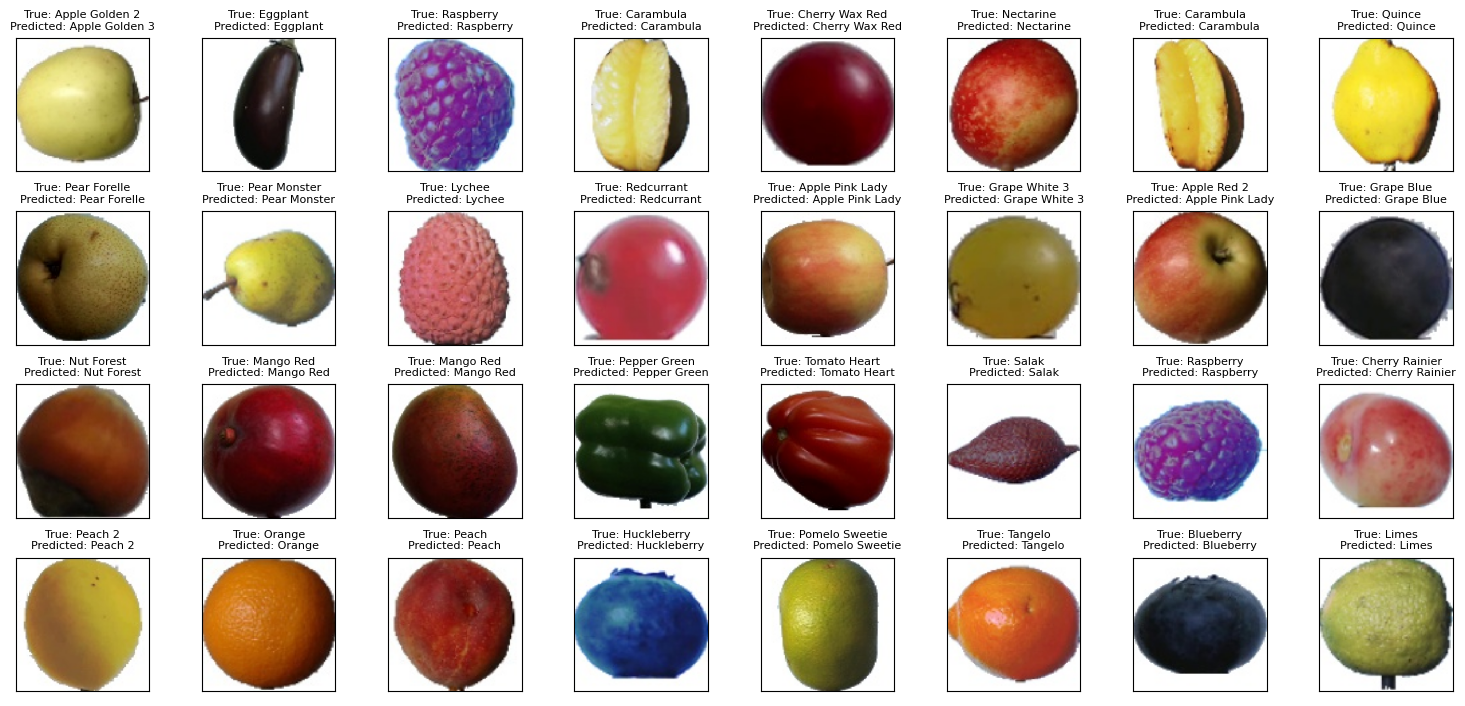

In [20]:
# Plotting a sample of images with predicted and true labels
plot_sample(xception_preprocess, model_xception)

## Resnet152

In [21]:
# Applying ResNet's preprocess function on train and test data generators
train_datagen.preprocessing_function = resnet_preprocess
test_datagen.preprocessing_function = resnet_preprocess

In [22]:
# Loading a pretrained model without the top
pretrained_model_resnet152 = ResNet152(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_resnet152.trainable = False

In [23]:
# Model construction and compilation
model_resnet152 = build_model(pretrained_model_resnet152)
model_resnet152.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Model learning
model_resnet152.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=2)

Epoch 1/2
1694/1694 [==============================] - 579s 337ms/step - loss: 0.2216 - accuracy: 0.9523 - val_loss: 0.0739 - val_accuracy: 0.9786
Epoch 2/2
1694/1694 [==============================] - 573s 338ms/step - loss: 0.0298 - accuracy: 0.9924 - val_loss: 0.0647 - val_accuracy: 0.9797


In [25]:
# Model evaluation
loss_resnet152, accuracy_resnet152 = model_resnet152.evaluate(test_gen)

709/709 [==============================] - 191s 270ms/step - loss: 0.1226 - accuracy: 0.9654


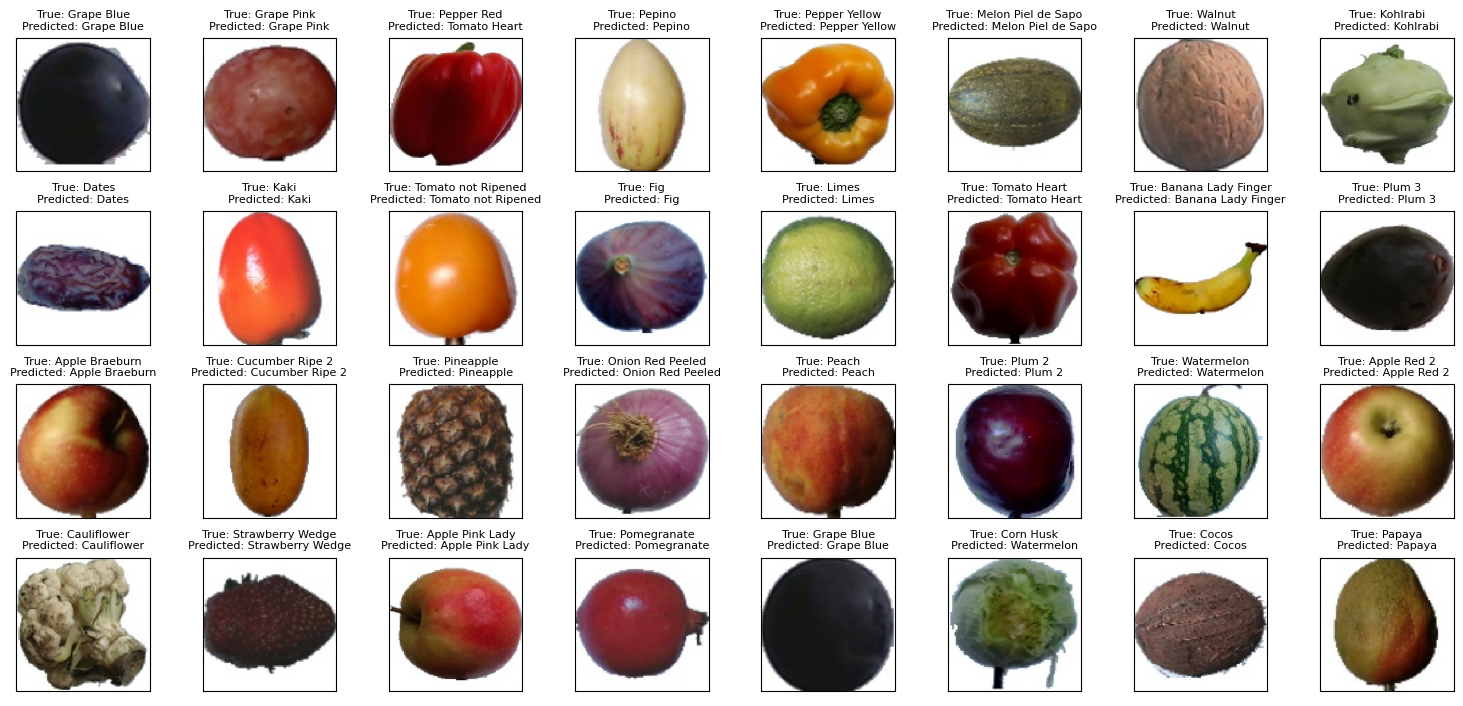

In [26]:
# Plotting a sample of images with predicted and true labels
plot_sample(resnet_preprocess, model_resnet152)

# Comparison of the three

In [27]:
loss_acc_df = pd.DataFrame([[loss_resnet152, accuracy_resnet152],
                            [loss_xception, accuracy_xception],
                            [loss_vgg16, accuracy_vgg16]],
                          columns = ["Loss", "Accuracy"],
                          index = ["ResNet152", "Xception", "VGG16"])

loss_acc_df

,Loss,Accuracy
ResNet152,0.122575,0.965356
Xception,0.385435,0.894790
VGG16,0.317358,0.935428
